In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults

import is3_broker_rl

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
sns.set_style("whitegrid")

In [2]:
DATA_DIR = Path(is3_broker_rl.__file__).parent.parent / "data"
NOTEBOOKS_DIR = Path(is3_broker_rl.__file__).parent.parent / "notebooks"

In [3]:
# t4_c1 = Trial 4, Training 2
df_action_t4_c2 = pd.read_csv(DATA_DIR / "trial4_consumption_training2" / "consumption_action.csv")
df_reward_t4_c2 = pd.read_csv(DATA_DIR / "trial4_consumption_training2" / "consumption_reward.csv")
# t4_c3 = Trial 4, Training 3
df_action_t4_c3 = pd.read_csv(DATA_DIR / "trial4_consumption_training3" / "consumption_action.csv")
df_reward_t4_c3 = pd.read_csv(DATA_DIR / "trial4_consumption_training3" / "consumption_reward.csv")

### Correlation between `capacity_costs` and `consumption_share`

In [4]:
df_reward_t4_c2.groupby("episode_id").mean(numeric_only=True)[["reward", "consumptionShare", "capacity_costs"]].corr()

,reward,consumptionShare,capacity_costs
reward,1.000000,-0.335359,0.823106
consumptionShare,-0.335359,1.000000,-0.652986
capacity_costs,0.823106,-0.652986,1.000000


### Piece-wise linear penalty for consumption share

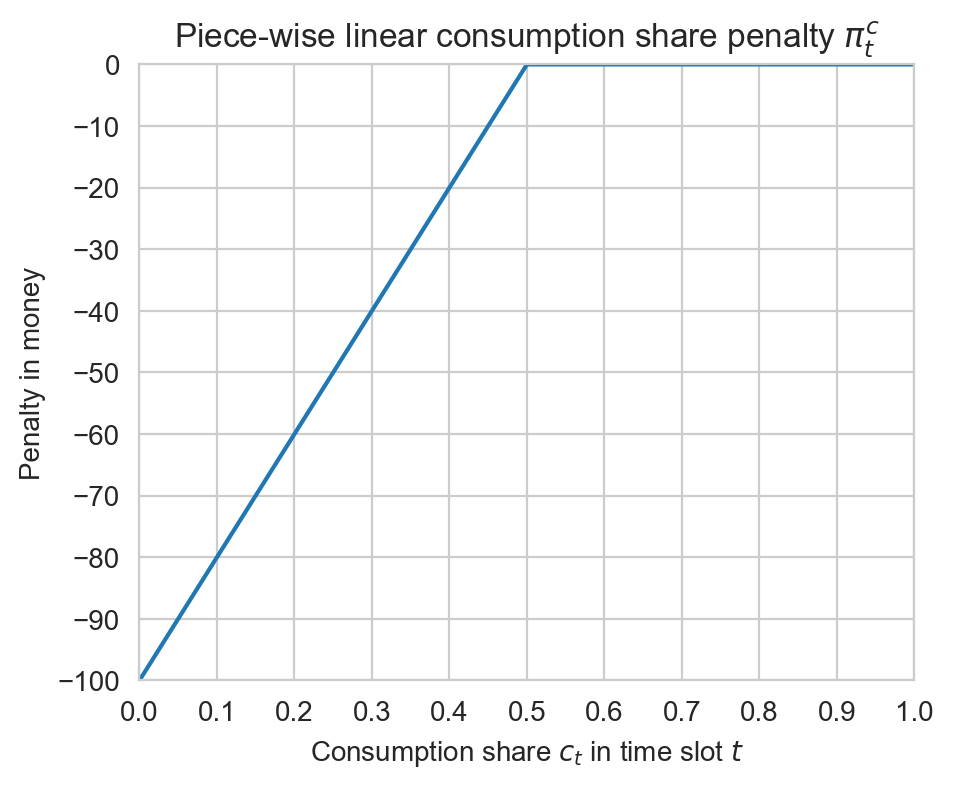

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
x = np.linspace(0, 1, 1000)
y = (0.5 - x) * -100 * np.power(0.5, -1)
y[y > 0] = 0
sns.lineplot(x=x, y=y, ax=ax)
ax.set_xmargin(0)
ax.set_ylim(-100, 0)
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_ticks(np.arange(-100, 10, 10))
ax.set_xlabel("Consumption share $c_t$ in time slot $t$")
ax.set_ylabel("Penalty in money")
ax.set_title("Piece-wise linear consumption share penalty $\pi_t^c$")
fig.savefig(NOTEBOOKS_DIR / "figures" / "piece-wise_linear_penalty.pdf")

### Confidence interval sample for reward function slope coefficient

In [6]:
def fit_episodic_reward_ols(df_reward: pd.DataFrame):
    df_episodic_reward = (
        df_reward.groupby("episode_id").mean(numeric_only=True).rolling(window=50).mean().dropna(axis=0).reset_index()
    )
    X = df_episodic_reward.index.to_numpy()
    X = sm.add_constant(X)
    y = df_episodic_reward["reward"].to_numpy()
    df_episodic_reward = sm.OLS(y, X)
    reg_results = df_episodic_reward.fit()
    return reg_results, X, y

In [7]:
def plot_reg_results(X: np.ndarray, y: np.ndarray, reg_results: RegressionResults):
    fig, ax = plt.subplots()
    sns.lineplot(x=X[:, 1], y=y, ax=ax)
    sns.lineplot(x=X[:, 1], y=np.dot(X, t4_c2_reg_results.params), ax=ax)

In [8]:
t4_c2_reg_results, t4_c2_X, t4_c2_y = fit_episodic_reward_ols(df_reward_t4_c2)
t4_c3_reg_results, t4_c3_X, t4_c3_y = fit_episodic_reward_ols(df_reward_t4_c3)

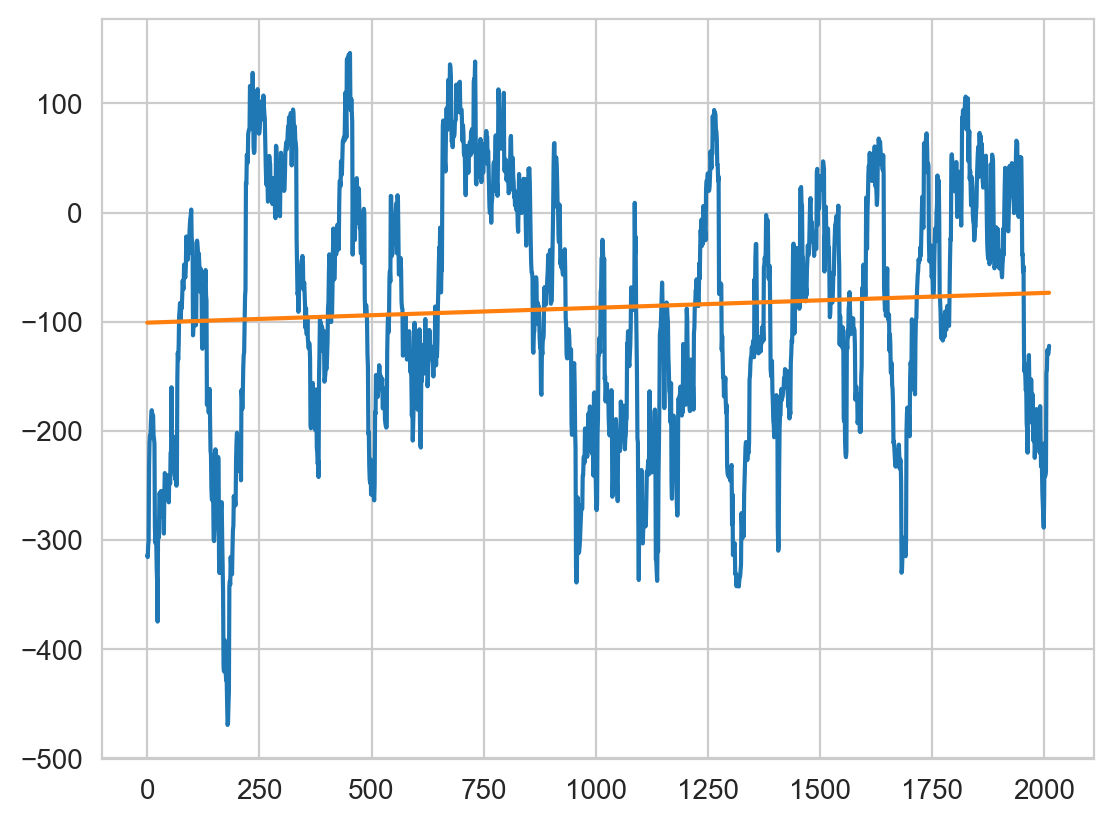

In [9]:
plot_reg_results(t4_c2_X, t4_c2_y, t4_c2_reg_results)

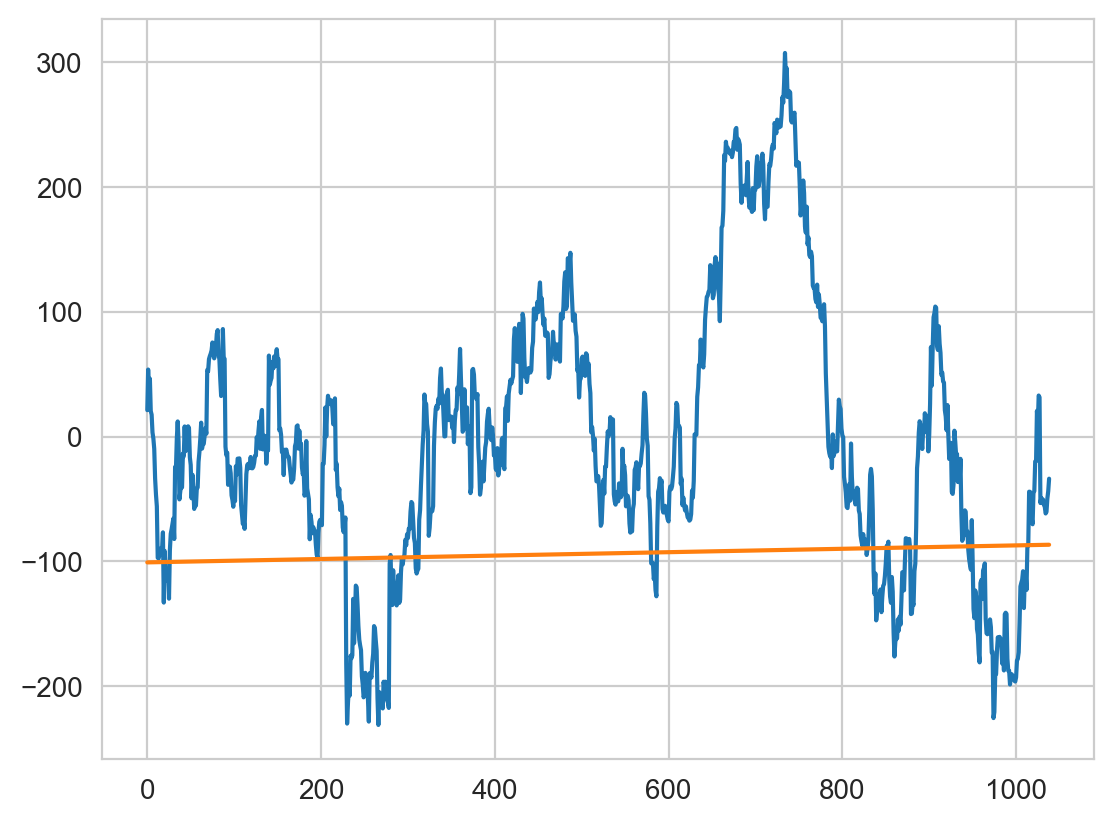

In [10]:
plot_reg_results(t4_c3_X, t4_c3_y, t4_c3_reg_results)